In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
import plotly.express as px
import cufflinks as cf
from  plotly.offline import plot

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report
import collections
from sklearn.metrics import classification_report


In [87]:
# importing class object that I created
import sys  
sys.path.insert(0, '../src/')
import utils

In [88]:
epi_data_df = pd.read_hdf('../data/processed/recipe_vectors.h5')

In [89]:
epi_data_df.shape

(48817, 4756)

In [90]:
epi_vector = pd.read_hdf('../data/processed/epi_vector.h5')

In [91]:
# tools = utils.tools() # create object

In [92]:
# epi_data_df = tools.readfile('../data/processed/epi_vector.h5')
# epi_data_df = tools.df

In [93]:
# new_data_df = tools.readfile('../data/processed/recipe_vectors.pickle')

In [94]:
# newdata_h5_df = tools.readfile('../data/processed/recipe_vectors.h5')

In [95]:
# newdata_h5_df = tools.df

In [96]:
# newdata_h5_df.shape

In [97]:
# new_data_df = tools.df

In [98]:
# new_data_df.tail(1)

In [99]:
epi_data_df.shape

(48817, 4756)

## Helper functions

In [100]:
epi_data_df.shape


(48817, 4756)

In [101]:
def countTags(sample_df):
    # Get count of tags

    c = Counter()  
    sample_df["tags"].apply(lambda x: c.update(x))
    # store tag count in df
    count = pd.DataFrame()
    count['tags_count'] = [c[i] for i in c]
    count['tag'] = [i for i in c]
    count = count.sort_values(by='tags_count',ascending=False)

    # delete row with value < n
    indexNames = count[ count['tags_count'] <= 30 ].index

    # Delete these row indexes from dataFrame
    count.drop(indexNames , inplace=True)
    return count


In [102]:
def getallergyTags(count):
    # look for ### Free tags
    count['allergy_tags'] = count['tag'].str.endswith('Free')

    allergy_df = count[count['allergy_tags'] == True]
    return allergy_df

In [103]:
# Create column in sample_df for allergy tags
def addallergytoDF(allergy_df,df):
    for i in allergy_df.tag:
        df[i] = [i in tags for tags in df.tags]
    return df

In [104]:
# I manually took out tags that are not recipe ingredients. And clean input. 
# Uncomment below if  cuisine type is needed
def loadCuisineType():
    cuisinetype = pd.read_csv('cuisinetype.txt',header=None)
    cuisinetype = cuisinetype.transpose()
    cuisinetype = np.array(cuisinetype[0])
    cuisinetype = [x.replace('\'','') for x in cuisinetype]
    cuisinetype = [x.replace('[','') for x in cuisinetype]
    cuisinetype = [x.replace(']','') for x in cuisinetype]
    cuisinetype = [x.lstrip() for x in cuisinetype]
    # print(cuisinetype)
    
    # Uncomment below if states are needed

    states = pd.read_csv('states.csv',header=None)
    states = states.transpose()
    states = np.array(states[0])
    states = [x.lstrip() for x in states]
    # print(states)
    
    # Uncomment below if usa_cuisine is needed

    city = pd.read_csv('usa_city.csv',header=None)
    city = city.transpose()
    city = np.array(city[0])
    city = [x.replace('\'','') for x in city]
    city = [x.replace('[','') for x in city]
    city = [x.replace(']','') for x in city]
    city = [x.lstrip() for x in city]
    usa_cuisine =states+city
    # print(usa_cuisine)
    
    non_usa_cuisine = []
    for i in cuisinetype:
        if i not in usa_cuisine:
            non_usa_cuisine.append(i)
    return usa_cuisine,non_usa_cuisine
    

In [105]:
def addCuisinetypesToDF(sample_df,usa_cuisine,non_usa_cuisine):
    tags_value=[]
    for tags in sample_df['tags']:
        if(set(tags).intersection(usa_cuisine)):
            tags_value.append(1)
            continue
        else:
            if(set(tags).intersection(non_usa_cuisine)):
                tags_value.append(0)
            else:
                tags_value.append(2)
    sample_df['usa_cuisine'] = tags_value
    return sample_df

In [106]:
# Drop column with all zeros
def dropZeroColumns(sample_df):
    sample_df = sample_df.loc[:, (sample_df != 0).any(axis=0)]
    return sample_df

In [107]:
def deleterows(df,column,value1,value2,yes):
    if(yes): # deleted row based on two values
        df = df.drop(df[df[column] == value1].index)
        df = df.drop(df[df[column] == value2].index)
    else:
        df = df.drop(df [df[column] == value1].index)
    return df

In [108]:
# drop not relevent columns and drop rest of allergy column except one you are analyzing
def dropColumn(sample_df,col):
#     sample_df = sample_df.drop(columns=['avg_rating','best_rating','prepare_again_rating','num_reviews'],axis=0)
    sample_df = sample_df[(sample_df != np.inf).all(axis=1)]
    sample_df = sample_df.drop(columns=col,axis=1)

    return sample_df

In [109]:

def getTrianData(sample_df,label_column):
    '''Seperate data and label to classify, 
    X are attribute columns used to classify, Y is the label
    first delete all infinity values in data. It also drop columns that are not needed.'''
    data = sample_df.drop(columns=label_column, axis=1)
    label = sample_df[label_column]
    return data,label


In [110]:
class SVCmodel(object):
    def __init__(self):
        pass
    def getSupport(self,model):
        '''Indices of support vectors'''
        return model.support_
    def getClassWeight(self,model):
        '''Support vectors'''
        return model.class_weight_
    def getNsupport(self,model):
        '''# of support vector for each class'''
        return model.n_support_
    def getsupportcoef(self,model):
        '''related to support vector in the decision function.'''
        return model.dual_coef_
    def getfeaturesweight(self,model):
        '''weight assigned to the features'''
        return model.coef_
    def getintercept(self,model):
        '''constants in decision function'''
        return model.intercept_
    def getfitstatus(self,model):
        '''0 if correctly fitted, 1 otherwise(will raise warning)'''
        return model.fit_status_
    def getclasses(self,model):
        '''The class label'''
        return model.classes_
    def getprobA(self,model):
        '''array type, shape = [n_class*(n_classes-1)/2]'''
        return model.probA_
    def getprobB(self,model):
        '''array type, shape = [n_class*(n_classes-1)/2].
        If probability=True, it corresponds to the parameters 
        learned in Platt scaling to produce probability estimates 
        from decision values. If probability=False, it’s an empty array. 
        Platt scaling uses the logistic function 
        1 / (1 + exp(decision_value * probA_ + probB_)) 
        where probA_ and probB_ are learned from the dataset 
        '''
        return model.probA_
    def getclassweight(self,model):
        '''multipliers of parameter C for each class.'''
        return model.class_weight_
    def getshapefit(self,model):
        return model.shape_fit_

## Data Preparation for Classification

In [111]:
%%time
# Cuisine Types: usa_cuisine ==> 1, non_usa_cuisine ==> 1, no_tags ==> 2
tags_count = countTags(epi_data_df)
usa_cuisine,non_usa_cuisine = loadCuisineType()
allergy_tags = getallergyTags(tags_count)
sample_df = epi_data_df.head(20000)
sample_df = addCuisinetypesToDF(sample_df,usa_cuisine,non_usa_cuisine)
cuisine_df = sample_df
sample_df = addallergytoDF(allergy_tags,sample_df)
sample_df = dropZeroColumns(sample_df)


CPU times: user 4.79 s, sys: 1.09 s, total: 5.88 s
Wall time: 7.27 s


In [112]:
epi_tags = countTags(epi_vector)
epi_tags.shape

(465, 2)

In [113]:
sample_df.head(2)

,Aleppo chili,Aleppo chili flake,Aleppo pepper,Amaretto,Amaretto liqueur,Amaro Montenegro,Amontillado sherry,Anaheim chili,Anaheim pepper,Ancho Chili Sauce,...,num_reviews,tags,title,usa_cuisine,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",1,False,False,False,False,False,False
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,"[Ginger, Dessert, Bake, Apple, Almond, Fall, R...","""An Apple a Day""",2,True,True,False,False,False,False


In [114]:
sample_df.shape

(20000, 3883)

In [115]:
# c[c['tag'] == 'Peanut']

In [116]:
# c[c['tag'] == 'Summer']
# c[c['tag'] == 'Winter']
# c[c['tag'] == 'Fall']
# c[c['tag'] == 'Spring']


In [117]:
def addSeasontypesToDF(sample_df,season,label):
    tags_value=[]
    print(season[0])
    for tags in sample_df['tags']:
        if(season[0] in set(tags)): #spring
            tags_value.append(1)
        elif(season[1] in set(tags)): #summer
            tags_value.append(2)
        elif(season[2] in set(tags)): #fall
            tags_value.append(3)
        elif(season[3] in set(tags)): #winter
            tags_value.append(4)
        else:
            tags_value.append(0) # for non-season food
    sample_df[label] = tags_value
    return sample_df

In [118]:
addSeasontypesToDF(sample_df,['Spring','Summer','Fall','Winter'],'season').head()

Spring


,Aleppo chili,Aleppo chili flake,Aleppo pepper,Amaretto,Amaretto liqueur,Amaro Montenegro,Amontillado sherry,Anaheim chili,Anaheim pepper,Ancho Chili Sauce,...,tags,title,usa_cuisine,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free,season
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",1,False,False,False,False,False,False,4
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"[Ginger, Dessert, Bake, Apple, Almond, Fall, R...","""An Apple a Day""",2,True,True,False,False,False,False,3
http://www.epicurious.com/recipes/food/views/-blanketed-eggplant-305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"[Tomato, Vegetable, Appetizer, Side, Vegetaria...","""Blanketed"" Eggplant",2,False,False,False,False,False,False,0
http://www.epicurious.com/recipes/food/views/-bloody-mary-tomato-toast-with-celery-and-horseradish-56389813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"[Condiment/Spread, Tomato, Appetizer, Kid-Frie...","""Bloody Mary"" Tomato Toast with Celery and Hor...",2,True,True,True,False,True,False,1
http://www.epicurious.com/recipes/food/views/-bow-tie-pasta-with-zucchini-101932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"[Pasta, Vegetarian, Quick & Easy, Dinner, Basi...","""Bow-Tie"" Pasta with Zucchini",2,True,True,True,False,False,False,2


In [119]:
c = Counter()
c.update(sample_df.season)
c

Counter({4: 2023, 3: 2533, 0: 10232, 1: 1528, 2: 3684})

In [120]:
sample_df.shape

(20000, 3884)

In [121]:
spring = []
summer = []
fall = []
winter =[]
spring_df = sample_df.tags[sample_df['season']==1].values
summer_df = sample_df.tags[sample_df['season']==2].values
fall_df = sample_df.tags[sample_df['season']==3].values
winter_df = sample_df.tags[sample_df['season']==4].values
non_season_df = sample_df.tags[sample_df['season'] == 0].values

In [122]:
s = Counter()
tags_list = []
count = 0
for tags in sample_df['tags']:
    if('Peanut' in tags):
#         print(tags)
        count +=1
        for i in tags:
            tags_list.append(i)

print("Tags list Containing Peanut Ingredient, but not Peanut Free tag",count)
s.update(tags_list)
s.most_common(10)

Tags list Containing Peanut Ingredient, but not Peanut Free tag 157


[('Peanut', 157),
 ('Tree Nut Free', 82),
 ('Soy Free', 76),
 ('Vegetarian', 72),
 ('Bon Appétit', 68),
 ('Pescatarian', 66),
 ('Kosher', 66),
 ('Dessert', 61),
 ('Gourmet', 54),
 ('Kid-Friendly', 50)]

In [123]:
tags_count.head()

,tags_count,tag,allergy_tags
19,16565,Peanut Free,True
20,16131,Soy Free,True
17,15512,Bon Appétit,False
34,14049,Tree Nut Free,True
3,13552,Vegetarian,False


In [124]:
tags_count

,tags_count,tag,allergy_tags
19,16565,Peanut Free,True
20,16131,Soy Free,True
17,15512,Bon Appétit,False
34,14049,Tree Nut Free,True
3,13552,Vegetarian,False
...,...,...,...
3437,31,dumpling,False
4774,31,cocktail ingredients,False
821,31,jalapenos,False
4385,31,buttercream,False


In [125]:
tags_count.shape

(881, 3)

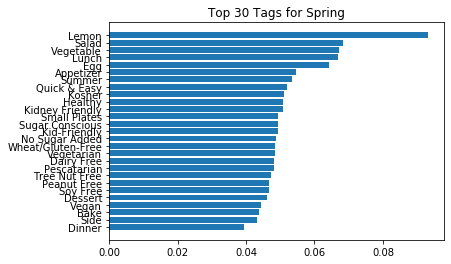

In [126]:
s = Counter()
for i in range(len(spring_df)):
#     print(spring_df[i])
    s.update(spring_df[i])
# for i in s.most_common(30):
#     if(i[0] != 'Spring' and i[0] !='Gourmet' and "Bon App" not in i[0]):
#         total = tags_count.tags_count[tags_count['tag'] == i[0]].values[0]
        
# print(s.most_common(10))
s = [(i[0],i[1]/tags_count.tags_count[tags_count['tag'] == i[0]].values[0]) for i in s.most_common(30) if(i[0] != 'Spring' and i[0] !='Gourmet' and "Bon App" not in i[0])]
# print('\n\n',s)
s = sorted(s, key = lambda x: x[1]) 
# print('\n\n',s)
keys = [x[0] for x in s]
values = [x[1] for x in s]
plt.barh(keys,values)
plt.title("Top 30 Tags for Spring")
plt.savefig('plots/springtag.png', bbox_inches='tight')
plt.show()

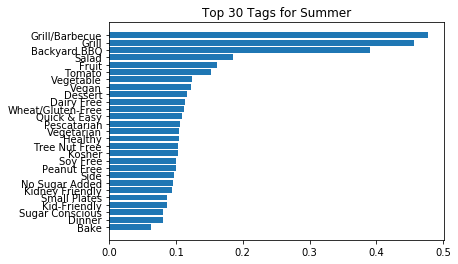

In [127]:
su = Counter()
for i in range(len(summer_df)):
    su.update(summer_df[i])
su = [(i[0],i[1]/tags_count.tags_count[tags_count['tag'] == i[0]].values[0]) for i in su.most_common(30) if(i[0] != 'Summer' and i[0] !='Gourmet' and "Bon App" not in i[0])]
su = sorted(su, key = lambda x: x[1]) 
keys = [x[0] for x in su]
values = [x[1] for x in su]
plt.barh(keys,values)
plt.title("Top 30 Tags for Summer")
plt.savefig('plots/summertag.png', bbox_inches='tight')
plt.show()

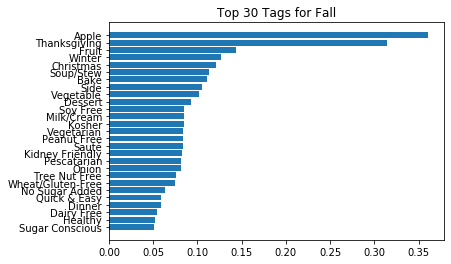

In [128]:
f = Counter()
for i in range(len(fall_df)):
    f.update(fall_df[i])
f = [(i[0],i[1]/tags_count.tags_count[tags_count['tag'] == i[0]].values[0]) for i in f.most_common(30) if(i[0] != 'Fall' and i[0] !='Gourmet' and "Bon App" not in i[0])]
f = sorted(f, key = lambda x: x[1]) 
keys = [x[0] for x in f]
values = [x[1] for x in f]
plt.barh(keys,values)
plt.title("Top 30 Tags for Fall")
plt.savefig('plots/falltag.png', bbox_inches='tight')
plt.show()

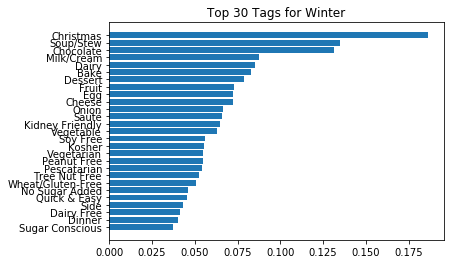

In [129]:
w = Counter()
for i in range(len(winter_df)):
    w.update(winter_df[i])
w = [(i[0],i[1]/tags_count.tags_count[tags_count['tag'] == i[0]].values[0]) for i in w.most_common(30) if(i[0] != 'Winter' and i[0] !='Gourmet' and "Bon App" not in i[0])]
w = sorted(w,key= lambda x:x[1])
keys = [x[0] for x in w]
values = [x[1] for x in w]
plt.barh(keys,values)
plt.title("Top 30 Tags for Winter")
plt.savefig('plots/wintertag.png', bbox_inches='tight')
plt.show()

In [130]:
# for i in sample_df.tags:
#     for j in i:
#         if(j == 'Peanut'):
#             print(i)

In [131]:
n = sample_df['tags'].str.contains('Peanut').values
print(len(np.isnan(n)))
len(n)

20000


20000

### Plot Correlation for Allergy Features

In [132]:
# sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
#             cmap=sns.diverging_palette(220, 10, as_cmap=True))

In [133]:
sample_df.shape

(20000, 3884)

In [134]:
allergy = ['Peanut Free','Soy Free','Tree Nut Free','Wheat/Gluten-Free','Dairy Free','Fat Free']
sample_df[allergy] *= 1
sample_df.head(1)

,Aleppo chili,Aleppo chili flake,Aleppo pepper,Amaretto,Amaretto liqueur,Amaro Montenegro,Amontillado sherry,Anaheim chili,Anaheim pepper,Ancho Chili Sauce,...,tags,title,usa_cuisine,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free,season
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",1,0,0,0,0,0,0,4


In [135]:
allergy_corr_df = sample_df[allergy]

In [136]:
print("Correlation Table for Allergy Tags")
allergy_corr_df.corr()

Correlation Table for Allergy Tags


,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free
Peanut Free,1.000000,0.940356,0.818149,0.530327,0.414655,0.138566
Soy Free,0.940356,1.000000,0.795322,0.544888,0.365398,0.138807
Tree Nut Free,0.818149,0.795322,1.000000,0.490006,0.428717,0.155550
Wheat/Gluten-Free,0.530327,0.544888,0.490006,1.000000,0.428693,0.194546
Dairy Free,0.414655,0.365398,0.428717,0.428693,1.000000,0.285322
Fat Free,0.138566,0.138807,0.155550,0.194546,0.285322,1.000000


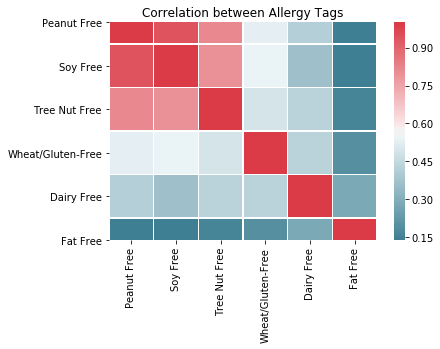

In [137]:
sns.heatmap(allergy_corr_df.corr(),xticklabels=allergy_corr_df.columns,yticklabels=allergy_corr_df.columns,linewidth=.5,cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.title("Correlation between Allergy Tags")
plt.savefig("allergycorr.png")
plt.show()

In [138]:
reviews = ['avg_rating','best_rating','prepare_again_rating','num_reviews']
review_df = sample_df[reviews].dropna()
review_df = review_df[review_df.columns].astype(float)


In [139]:
review_df.corr()

,avg_rating,best_rating,prepare_again_rating,num_reviews
avg_rating,1.000000,0.073654,0.824393,0.218885
best_rating,0.073654,1.000000,0.065569,0.014233
prepare_again_rating,0.824393,0.065569,1.000000,0.211160
num_reviews,0.218885,0.014233,0.211160,1.000000


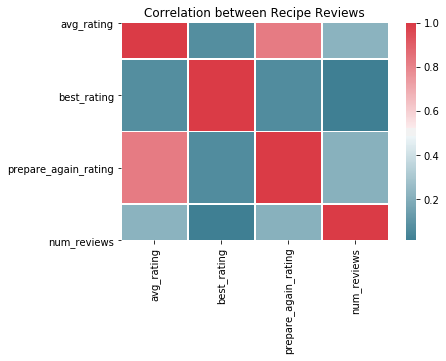

In [140]:
sns.heatmap(review_df.corr(),xticklabels=review_df.columns,yticklabels=review_df.columns,linewidth=.5,cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.title("Correlation between Recipe Reviews")
plt.savefig("reiviewcorr.png")
plt.show()

In [141]:
sample_df[allergy].shape

(20000, 6)

In [142]:
sample_df[allergy].apply(pd.value_counts)

,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free
0,10687,10906,12220,14718,16845,19635
1,9313,9094,7780,5282,3155,365


In [143]:
# sample_df[allergy][(sample_df['Peanut Free'] == 1) & (sample_df['usa_cuisine'] == 1)].shape

In [144]:
for i in allergy[:-1]:
    print(i)

Peanut Free
Soy Free
Tree Nut Free
Wheat/Gluten-Free
Dairy Free


In [145]:
copy = sample_df[allergy]
copy.head()

,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0,0,0,0,0,0
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,1,1,0,0,0,0
http://www.epicurious.com/recipes/food/views/-blanketed-eggplant-305,0,0,0,0,0,0
http://www.epicurious.com/recipes/food/views/-bloody-mary-tomato-toast-with-celery-and-horseradish-56389813,1,1,1,0,1,0
http://www.epicurious.com/recipes/food/views/-bow-tie-pasta-with-zucchini-101932,1,1,1,0,0,0


In [146]:
# copy = copy[(copy['usa_cuisine'] != 2)]

In [147]:
def plotgraph(df,title,x):
    df.plot.hist(x=x,y='usa_cuisine',figsize=(5,5),grid=True)
    plt.title(title)
    plt.xlabel('usa_cuisine')
    plt.ylabel(x)
    

In [148]:
c[c['allergy_tags']==True]

10232

In [149]:
# # copy = dropColumn(copy,['avg_rating','best_rating','prepare_again_rating','num_reviews','tags','title'])
# # print(copy.shape)
# for i in allergy:
#     allergy_df = copy[(copy[i] == 1)]
#     allergy_df = allergy_df[['usa_cuisine',i]]
# #     print(allergy_df.head())
# #     print(allergy_df.shape)
#     allergy_df.plot.hist(x=i,y='usa_cuisine',figsize=(5,3),grid=True)
#     plt.title('Cuisine and Allergy')
#     plt.xlabel('usa_cuisine')
#     plt.ylabel(i)
# #     plotgraph(allergy_df,'Cuisine and Allergy',i)
    


In [150]:
copy.head()

,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0,0,0,0,0,0
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,1,1,0,0,0,0
http://www.epicurious.com/recipes/food/views/-blanketed-eggplant-305,0,0,0,0,0,0
http://www.epicurious.com/recipes/food/views/-bloody-mary-tomato-toast-with-celery-and-horseradish-56389813,1,1,1,0,1,0
http://www.epicurious.com/recipes/food/views/-bow-tie-pasta-with-zucchini-101932,1,1,1,0,0,0


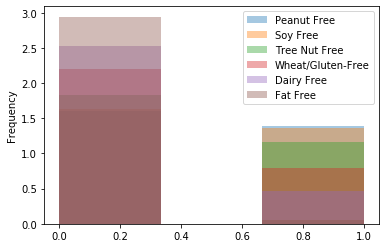

In [151]:
copy.plot.hist(alpha=0.4,density=True,bins=3)
plt.show()

### Deletes Not used columns

In [152]:
drop_column = ['avg_rating','best_rating','prepare_again_rating','num_reviews','usa_cuisine','tags','title','season']
label_column = ['Peanut Free','Soy Free','Tree Nut Free','Wheat/Gluten-Free','Dairy Free','Fat Free']

# copy1 = sample_df
# copy2 = sample_df
# usa_tag_df = deleterows(copy1,'usa_cuisine',2,'',True)
# no_cuisine_tag_df = deleterows(copy2,'usa_cuisine',1,0,False)


In [153]:
sample_df.head()

,Aleppo chili,Aleppo chili flake,Aleppo pepper,Amaretto,Amaretto liqueur,Amaro Montenegro,Amontillado sherry,Anaheim chili,Anaheim pepper,Ancho Chili Sauce,...,tags,title,usa_cuisine,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free,season
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",1,0,0,0,0,0,0,4
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"[Ginger, Dessert, Bake, Apple, Almond, Fall, R...","""An Apple a Day""",2,1,1,0,0,0,0,3
http://www.epicurious.com/recipes/food/views/-blanketed-eggplant-305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"[Tomato, Vegetable, Appetizer, Side, Vegetaria...","""Blanketed"" Eggplant",2,0,0,0,0,0,0,0
http://www.epicurious.com/recipes/food/views/-bloody-mary-tomato-toast-with-celery-and-horseradish-56389813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"[Condiment/Spread, Tomato, Appetizer, Kid-Frie...","""Bloody Mary"" Tomato Toast with Celery and Hor...",2,1,1,1,0,1,0,1
http://www.epicurious.com/recipes/food/views/-bow-tie-pasta-with-zucchini-101932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"[Pasta, Vegetarian, Quick & Easy, Dinner, Basi...","""Bow-Tie"" Pasta with Zucchini",2,1,1,1,0,0,0,2


In [154]:
sample_df = dropColumn(sample_df,drop_column)

In [155]:
sample_df.head(1)

,Aleppo chili,Aleppo chili flake,Aleppo pepper,Amaretto,Amaretto liqueur,Amaro Montenegro,Amontillado sherry,Anaheim chili,Anaheim pepper,Ancho Chili Sauce,...,zucchini,zucchini blossom,zucchini flower,zucchini squash,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0


In [156]:
# usa_tag_df
# label_column

In [157]:
training_data,test_data = train_test_split(sample_df,test_size= 0.2)
train_data,train_label = getTrianData(training_data,label_column)
test_data,test_label = getTrianData(test_data,label_column)

In [158]:
# train_data,train_label = getTrianData(training_data,label_column)
# test_data,test_label = getTrianData(test_data,label_column)

In [159]:
train_data.head(2)

,Aleppo chili,Aleppo chili flake,Aleppo pepper,Amaretto,Amaretto liqueur,Amaro Montenegro,Amontillado sherry,Anaheim chili,Anaheim pepper,Ancho Chili Sauce,...,zest lemon,zest lime,zest navel orange,zest orange,ziti,ziti pasta,zucchini,zucchini blossom,zucchini flower,zucchini squash
http://www.epicurious.com/recipes/food/views/baked-apples-with-prunes-almonds-and-amaretto,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/endive-and-asiago-salad-240084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [160]:
train_label.head(2)

,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free
http://www.epicurious.com/recipes/food/views/baked-apples-with-prunes-almonds-and-amaretto,0,0,0,1,0,0
http://www.epicurious.com/recipes/food/views/endive-and-asiago-salad-240084,1,1,1,1,0,0


In [161]:
test_data.head(2)

,Aleppo chili,Aleppo chili flake,Aleppo pepper,Amaretto,Amaretto liqueur,Amaro Montenegro,Amontillado sherry,Anaheim chili,Anaheim pepper,Ancho Chili Sauce,...,zest lemon,zest lime,zest navel orange,zest orange,ziti,ziti pasta,zucchini,zucchini blossom,zucchini flower,zucchini squash
http://www.epicurious.com/recipes/food/views/danish-celeriac-salad-20116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/duck-with-port-cherry-sauce-104189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Support Vector Classifier

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

Below website gives good explaination on reading result from SVC

https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python

### Fit model without weights

Referenced example from this link: https://www.geeksforgeeks.org/classifying-data-using-support-vector-machinessvms-in-python/

In [176]:
tags_count.head(1)

,tags_count,tag,allergy_tags
19,16565,Peanut Free,True


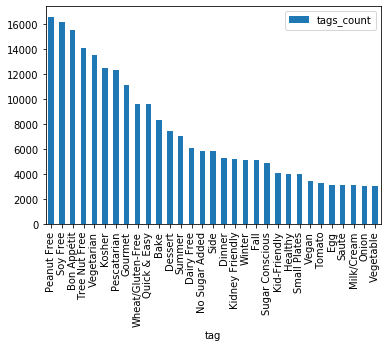

In [197]:
tags_count[tags_count['tags_count'] >= 3000].plot(kind='bar',y='tags_count',x='tag')
plt.savefig('plots/tags_freq.png',bbox_inches='tight')
plt.show()

In [169]:
svc = svm.SVC(kernel='linear')
# w_svc = svm.NuSVC(nu = 0.1, gamma='auto',class_weight={0:weight_ratio[0][0]},kernel='linear')


In [170]:
train_label.head(1)

,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free
http://www.epicurious.com/recipes/food/views/baked-apples-with-prunes-almonds-and-amaretto,0,0,0,1,0,0


In [171]:
new_labels = np.asarray(train_label.values)
new_labels

array([[0, 0, 0, 1, 0, 0],
       [1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [172]:
test_data.shape

(4000, 3870)

In [175]:
p = svc.predict(test_data.iloc[:])

NotFittedError: This SVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [174]:
c = Counter()
c.update(test_label['Peanut Free'])
print("SVC-No Weight")
print("Actual label count ",c)
c = Counter()
c.update(p)
print("prediction label count ",c)

SVC-No Weight
Actual label count  Counter({0: 2131, 1: 1869})


NameError: name 'p' is not defined

In [ ]:
print("\n\n          SVC Classificatin Report-No Weight\n\n")
print(classification_report(test_label['Peanut Free'],p))

In [ ]:
train_size = 1000

In [ ]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(svc, classes=['Peanut Free','Not Peanut Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Peanut Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Peanut Free'].iloc[:train_size])        # Evaluate the model on the test data
plt.title("SVC Classification Report-Peanut")
plt.savefig('no_weight_peanut_svc_result.png')
visualizer.show() 

In [ ]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(svc, classes=['Soy Free','Not Soy Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Soy Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Soy Free'].iloc[:train_size])        # Evaluate the model on the test data
plt.title("SVC Classification Report-Soy")
plt.savefig('no_weight_soy_svc_result.png')
visualizer.show() 

In [ ]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(svc, classes=['Tree Nut Free','Not Tree Nut Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Tree Nut Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Tree Nut Free'].iloc[:train_size])        # Evaluate the model on the test data
plt.title("SVC Classification Report-Tree Nut")
plt.savefig('no_weight_treenut_svc_result.png')
visualizer.show() 

In [ ]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(svc, classes=['Dairy Free','Not Dairy Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Dairy Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Dairy Free'].iloc[:train_size])        # Evaluate the model on the test data
plt.title("SVC Classification Report-Dairy")
plt.savefig('no_weight_dairy_svc_result.png')
visualizer.show() 

In [ ]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(svc, classes=['Fat Free','Not Fat Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Fat Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Fat Free'].iloc[:train_size])        # Evaluate the model on the test data
plt.title("SVC Classification Report-Fat")
plt.savefig('no_weight_fat_svc_result.png')
visualizer.show() 

In [ ]:
%%time
peanut.predict(test_data)

In [ ]:
# val = []
# for i in train_label:
#     v = i.replace(' ','')
#     val.append(v)
# val

In [ ]:
# allergy_predict = []
# j = 0
# for i in train_label:
#     print(val[j])
#     val[j] = svc.fit(train_data.iloc[:train_size], np.asarray(train_label[i].iloc[:train_size].values)) 
#     allergy_predict.append(val[j])
#     j +=1
# allergy_predict

### Fit model with weights

#### Calculate Weight

* sample_weight is to be applied to individual samples (rows in your data). So the length of sample_weight must match the number of samples in your X.

* class_weight is to make the classifier give more importance and attention to the classes. So the length of class_weight must match the number of classes in your targets.

In [ ]:
count1 = len(cuisine_df.loc[cuisine_df['usa_cuisine'] == 1]) # true
count2 = len(cuisine_df.loc[cuisine_df['usa_cuisine'] == 0]) # false
count3 = len(cuisine_df.loc[cuisine_df['usa_cuisine'] == 2]) # NA
print("Neither USA Cuisine or non-USA Cuisine: ",count3)
print("USA Cuisine: ",count1)
print("Non-USA Cuisine: ",count2)

In [ ]:
print(len(train_label))

In [ ]:
weight_ratio = []
for i in train_label:
    max_v = [int(train_label[i][train_label[i] == 0].value_counts())/len(train_label),int(train_label[i][train_label[i] == 1].value_counts())/len(train_label)]
    print(max_v)
    weight_ratio.append(max_v)
weight_ratio

In [ ]:
weight_ratio[0][0]

In [ ]:
degree = [1, 1, 2, 3, 4, 1, 1, 1, 1, 2, 3, 4, 1, 1, 1, 1, 2]
degree
kernel =['linear', 'poly', 'poly', 'poly', 'poly', 'rbf', 'sigmoid',
        'linear', 'poly', 'poly', 'poly', 'poly', 'rbf', 'sigmoid',
        'linear', 'poly', 'poly']
nu = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.1 , 0.1 , 0.1 , 0.1 ,
        0.1 , 0.1 , 0.1 , 0.15, 0.15, 0.15]
acc_list = [0.90653153, 0.90728228, 0.61473974, 0.56681682, 0.53440941,
        0.75525526, 0.50287788, 0.90840841, 0.90578078, 0.60047548,
        0.56881882, 0.53553554, 0.75575576, 0.5289039 , 0.90515516,
        0.90302803, 0.5701952 ]
# degree,kernel,nu,acc_list

In [ ]:
svc_df = pd.DataFrame()
svc_df['Degree'] = degree
svc_df['Kernel'] = kernel
svc_df['Nu'] = nu
svc_df['Accuracy'] = acc_list
svc_df

In [ ]:
import mplcursors

In [ ]:
plt.scatter(degree,acc_list,alpha=0.5,color='red',label='Degree')
plt.scatter(kernel,acc_list,alpha=0.4,color='blue',label='Kernel')
plt.scatter(nu,acc_list,alpha=0.4,color='green',label='Nu')
plt.legend()
mplcursors.cursor(hover=True)
plt.title("SVC accuracy based on Input Parameters")
plt.savefig("svc_accury_by_parameters.png")
plt.show()

In [ ]:
plt.scatter(kernel,acc_list,alpha=0.4)
plt.title("SVC accuracy based on Kernel")
plt.savefig("accuracy_by_kernel.png")
plt.show()

In [ ]:
plt.scatter(nu,acc_list,alpha=0.4)
plt.title("SVC accuracy based on Nu")
plt.savefig("accuracy_by_nu.png")
plt.show()

## Single Class Classification

In [ ]:
train_size

In [ ]:
%%time
w_svc = svm.NuSVC(nu = 0.1, gamma='auto',class_weight={0:weight_ratio[0][0]},kernel='linear')
w_svc.fit(train_data.iloc[:train_size], train_label['Peanut Free'][:train_size])#,sample_weight=cal_w) 

In [ ]:
test_data.head()

In [ ]:
train_size = 1000

In [ ]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(w_svc, classes=['Peanut Free','Not Peanut Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Peanut Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Peanut Free'].iloc[:train_size])        # Evaluate the model on the test data
visualizer.show() 

In [ ]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(w_svc, classes=['Soy Free','Not Soy Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Soy Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Soy Free'].iloc[:train_size])        # Evaluate the model on the test data
visualizer.show() 

In [ ]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(w_svc, classes=['Tree Nut Free','Not Tree Nut Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Tree Nut Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Tree Nut Free'].iloc[:train_size])        # Evaluate the model on the test data
visualizer.show() 

In [ ]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(w_svc, classes=['Dairy Free','Not Dairy Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Dairy Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Dairy Free'].iloc[:train_size])        # Evaluate the model on the test data
visualizer.show() 

In [ ]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(w_svc, classes=['Fat Free','Not Fat Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Fat Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Fat Free'].iloc[:train_size])        # Evaluate the model on the test data
visualizer.show() 

In [ ]:
%%time
p = w_svc.predict(test_data)

In [ ]:
print("\n\n          SVC Classificatin Report-With Weight\n\n")

print(classification_report(test_label['Peanut Free'],p))

In [ ]:
c = Counter()
c.update(test_label['Peanut Free'])
print("SVC - With Weight")
print("actual label count:",c)
c = Counter()
c.update(p)
print("prediction label count:",c)

In [ ]:
c = Counter()
c.update(p)
print("prediction label count ",c)

## Naive Bayes Classifier

In [ ]:
# # create a guassian classifier
bayes_model = GaussianNB()
bayes_model.fit(train_data,train_label['Peanut Free'])
print(bayes_model.epsilon_)

In [ ]:
p = bayes_model.predict(test_data)

In [ ]:
print("\n\n          Naive Bayes Classificatin Report\n\n")

print(classification_report(test_label['Peanut Free'],p))

In [ ]:
c = Counter()
c.update(test_label['Peanut Free'])
print("Naive Bayes Classifier")
print("actual label count:",c)
c = Counter()
c.update(bayes_model.predict(test_data))
print("prediction label count:",c)

In [ ]:
c = Counter()
c.update(bayes_model.predict(test_data))
print("prediction label count ",c)

Example of computing class_weight

https://programtalk.com/python-examples/sklearn.utils.class_weight.compute_class_weight/

In [ ]:
# %%time 
# best_nu = -1
# best_acc = -1
# best_degree = -1
# best_kernel = ''
# w = -1

# nu = []
# degree = []
# kernel = []
# acc_list = []
# for n in range(1,9):
#     nu_v = 0.1*n
#     w += 1
#     for k in ["linear", "poly", "rbf", "sigmoid"]:
#         for d in range(1,10):
#             avg_acc = 0
#             for i in range(10):
#                 training_data,test_data = train_test_split(sample_df,test_size= 0.2)
#                 train_data,train_label = getTrianData(training_data,label_column[0])
#                 test_data,test_label = getTrianData(test_data,label_column[0])
# #                 new_labels = np.asarray(train_label.values)
# #                 c = Counter()
# #                 c.update(new_labels)
# #                       #degree_v = 0.05*i
#                 w_svc = svm.NuSVC(nu = nu_v, kernel=k, gamma='auto',degree = d, class_weight={0:weight_ratio[0][0]},probability=True)
# #                 print("fitting model")
#                 w_svc.fit(train_data.iloc[:train_size], train_label.iloc[:train_size])#,sample_weight=cal_w) 
# #                 print("predicting now")
#                 y_pred = w_svc.predict(test_data)
#                 acc = 0
#                 for idx, val in enumerate(y_pred):
#                     #print(test_label)
#                     if val == test_label.values[idx]:
#                         acc += 1
#                 acc /= len(y_pred)
#                 avg_acc += acc
#                 print('{}: {}'.format(i,acc))
#             avg_acc /= 4
#             print('Kernel: {}, nu: {}, Degree: {} , Avg Acc: {} '.format(k,nu_v, d, avg_acc))
#             if avg_acc > best_acc:
#                 degree.append(d)
#                 kernel.append(k)
#                 nu.append(nu_v)
#                 acc_list.append(avg_acc)
#             if k != "poly":
#                 break

                

In [ ]:
# svc_para = pd.DataFrame()
# svc_para['best_degree'] = degree
# svc_para['best_kernel'] = kernel
# svc_para['best_nu'] = nu
# svc_para['best_acc'] = acc_list

In [ ]:
# svc_para

In [ ]:
# # gca stands for 'get current axis'
# ax = plt.gca()

# svc_para.plot(kind='line',x='best_acc',y='best_degree',ax=ax)
# # svc_para.plot(kind='line',x='best_acc',y='best_kernel', color='red', ax=ax)
# svc_para.plot(kind='line',x='best_acc',y='best_nu', color='yellow', ax=ax)

# plt.show()

In [ ]:
# svc_para.plot.bar(x=['best_acc'],y=['best_degree','best_kernel','best_nu'],alpha=0.4)
# plt.title("SVC accuracy based on Nu")
# plt.show()

## Not Used Code

In [ ]:
# uncomment below lines to replace column with number greater than 0 to 1 to make it binary.
# columns = ['avg_rating','best_rating','worst_rating','prepare_again_rating','num_reviews','total_time', 'tags', 'title']
# df = sample_df.copy()
# for col in sample_df.columns:
#     if col not in columns:
#         df.loc[df[col] > 0, col] = 1
# df.head(25)

In [ ]:
# len(sample_df[["Breakfast" in x for x in sample_df.tags]])

In [ ]:
# Uncomment below if need to encode data into unique value 


# from sklearn import preprocessing
# # label encoder
# le = preprocessing.LabelEncoder()

# # Converting string labels into numbers
# label = le.fit_transform(Y) # 0 ==> False, 1 ==> True
# label

# Uncomment below if need to convert X data into encoder and turn it into tuple list
#data.apply(le.fit_transform)
#data = [tuple(r) for r in data.values.tolist()]

In [ ]:
# uncomment below if need to look for inf value in data 
# for col in X.columns:
#     print(X.loc[X[col] > 100000, col])

### Example from Sklearn Website

https://scikit-learn.org/stable/auto_examples/svm/plot_weighted_samples.html

In [ ]:
print(__doc__)

def plot_decision_function(classifier, sample_weight, axis, title):
    # plot the decision function
    xx, yy = np.meshgrid(np.linspace(-4, 5, 500), np.linspace(-4, 5, 500))

    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the line, the points, and the nearest vectors to the plane
    axis.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.bone)
    axis.scatter(X[:, 0], X[:, 1], c=y, s=100 * sample_weight, alpha=0.9,
                 cmap=plt.cm.bone, edgecolors='black')

    axis.axis('off')
    axis.set_title(title)


# we create 20 points
np.random.seed(0)
X = np.r_[np.random.randn(10, 2) + [1, 1], np.random.randn(10, 2)]
y = [1] * 10 + [-1] * 10
sample_weight_last_ten = abs(np.random.randn(len(X)))
sample_weight_constant = np.ones(len(X))
# and bigger weights to some outliers
sample_weight_last_ten[15:] *= 5
sample_weight_last_ten[9] *= 15

# for reference, first fit without sample weights
print(sample_weight_last_ten)
# fit the model
clf_weights = svm.SVC(gamma=1)
clf_weights.fit(X, y, sample_weight=sample_weight_last_ten)

clf_no_weights = svm.SVC(gamma=1)
clf_no_weights.fit(X, y)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_decision_function(clf_no_weights, sample_weight_constant, axes[0],
                       "Constant weights")
plot_decision_function(clf_weights, sample_weight_last_ten, axes[1],
                       "Modified weights")

plt.show()

In [ ]:
# a = -class_weight[0] / class_weight[1]

# xx = np.linspace(0,50)
# yy = a * xx - feature_weight[0].max() / class_weight[1]
# print(xx.min(),yy.max())
# h0 = plt.plot(xx, yy, 'k-', label="non weighted div")

# plt.scatter(x, y,c=y)
# plt.ylim(yy.min(),50)
# plt.xlim(xx.min(),50)
# plt.legend()
# plt.show()

In [ ]:

# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn import svm, datasets

# # import some data to play with
# iris = datasets.load_iris()
# X = data.iloc[:1000, :100]  # we only take the first two features. We could
#                       # avoid this ugly slicing by using a two-dim dataset
# y = label.iloc[:1000]

# h = .02  # step size in the mesh

# # we create an instance of SVM and fit out data. We do not scale our
# # data since we want to plot the support vectors
# C = 1.0  # SVM regularization parameter
# svc = svm.SVC(kernel='linear', C=C).fit(X, y)
# rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
# poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
# lin_svc = svm.LinearSVC(C=C).fit(X, y)

# # create a mesh to plot in
# x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
# y_min, y_max = X.iloc[:, 100].min() - 1, X.iloc[:, 100].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                      np.arange(y_min, y_max, h))

# # title for the plots
# titles = ['SVC with linear kernel',
#           'LinearSVC (linear kernel)',
#           'SVC with RBF kernel',
#           'SVC with polynomial (degree 3) kernel']


# for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
#     # Plot the decision boundary. For that, we will assign a color to each
#     # point in the mesh [x_min, x_max]x[y_min, y_max].
#     plt.subplot(2, 2, i + 1)
#     plt.subplots_adjust(wspace=0.4, hspace=0.4)

#     Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

#     # Put the result into a color plot
#     Z = Z.reshape(xx.shape)
#     plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

#     # Plot also the training points
#     plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.coolwarm)
#     plt.xlabel('Sepal length')
#     plt.ylabel('Sepal width')
#     plt.xlim(xx.min(), xx.max())
#     plt.ylim(yy.min(), yy.max())
#     plt.xticks(())
#     plt.yticks(())
#     plt.title(titles[i])

# plt.show()

In [ ]:
# plot_decision_function(clf,clf.class_weight_,axes[0],'SVC without weights')

In [ ]:
# from sklearn.datasets.samples_generator import make_blobs 

# x,y = make_blobs(n_samples=100,centers=3,n_features=3)
# plt.scatter(x[:, 0], x[:, 1], c=y, s=50, cmap='spring'); 
# plt.show()  